FileName: initial_model_development.ipynb

Developer: Tanmoy Das
Date: June 11, 2023

Outline of this script:
1. Input data
2. Optimization Model
3. Output in a form of Network Diagram ++

# Data

## Data importing

In [1]:
# import custom functions
import data_preparation
import custom_func
import model
import model_analysis
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
# Import data
spill_data = pd.read_excel('Inputs/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()
station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()
# spill_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='spills', header=0).copy()
# spill_data = spill_data.sample(n=100)

In [3]:
spill_data.head()
station_data.head()

,no.,Station #,Station,Name,Coordinates,skimmers,booms,dispersant,burning,Resources total,Converted resources,Capacity,Unnamed: 12,Unnamed: 13
0,1,s1,Station 1,Beafort sea,"(70,-134)",0,1,33,NaN,34,NaN,0,NaN,NaN
1,2,s2,Station 2,Northwestern passage,"(70.64, -119.43)",8,8,55,NaN,71,NaN,80,NaN,NaN
2,3,s3,Station 3,Kitikmeot Region,"(67.09, -112.32)",1,4,58,NaN,63,NaN,80,NaN,NaN
3,4,s4,Station 4,Fort Smith,"(62.60, -113.19)",10,3,32,NaN,45,NaN,80,NaN,NaN
4,5,s5,Station 5,Hay River,"(60.53, -114.38)",40,10,100,NaN,150,NaN,0,NaN,NaN


## Data Preprocessing

In [4]:
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [5]:
# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

## Scalar inputs of the models

In [6]:
DistanceMax = 10

BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

# How many facilities to build

## 200 spills

In [37]:
# spill_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='spills', header=0).copy()
# spill_data = spill_data.sample(n=200)
# spill_data.to_csv('Inputs/data_200_oil_spills.csv')
spill_data200 = pd.read_csv('Inputs/data_200_oil_spills.csv')


In [38]:
# Spill data processing
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= data_preparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)


['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [39]:
# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))


In [40]:
NumberStMaxL = [15, 12, 8, 5, 4, 2]
number_of_spillsL = [200, 200, 200, 200, 200, 200]
select_1sL =[]
coverage_percentageL =[]
MeanResponseTimeL =[]

In [41]:
for i in range(6):
    model01, select, deploy, mvars, names, values, objValues, \
            spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
        = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
              Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[i], Distance, Distance_n,
              W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
              BigM, MaxFO)
    select_1sL.append(select_1s.index)
    coverage_percentageL.append(coverage_percentage)
    MeanResponseTimeL.append(MeanResponseTime)


--------------MIP-moo--------
cover
{('o49', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o49', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o49', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o49', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o49', 's18'): <gurobi.Var *Awaiting Model Update*>, ('o156', 's2'): <gurobi.Var *Awaiting Model Update*>, ('o156', 's3'): <gurobi.Var *Awaiting Model Update*>, ('o156', 's4'): <gurobi.Var *Awaiting Model Update*>, ('o156', 's5'): <gurobi.Var *Awaiting Model Update*>, ('o156', 's6'): <gurobi.Var *Awaiting Model Update*>, ('o28', 's1'): <gurobi.Var *Awaiting Model Update*>, ('o120', 's12'): <gurobi.Var *Awaiting Model Update*>, ('o120', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o123', 's9'): <gurobi.Var *Awaiting Model Update*>, ('o123', 's12'): <gurobi.Var *Awaiting Model Update*>, ('o114', 's12'): <gurobi.Var *Awaiting Model Update*>, ('o114', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o169', 's1'): <gurobi.Var *Awaiting Mod

In [42]:
determine_number_of_facilities = pd.DataFrame(index=range(6),
                                              columns=['Number of facilities', 'Number of spills','Open facility', 'Coverage (%)', 'Mean Response time (in hours)', 'Cost investment (in million CAD)'])
for i in range(6):
    determine_number_of_facilities.iloc[i,0] = NumberStMaxL[i]
    determine_number_of_facilities.iloc[i,1] = number_of_spillsL[i]
    determine_number_of_facilities.iloc[i,2] = select_1sL[i]
    determine_number_of_facilities.iloc[i,3] = coverage_percentageL[i]
    determine_number_of_facilities.iloc[i,4] = MeanResponseTimeL[i]
    determine_number_of_facilities.iloc[i,5] = 0
determine_number_of_facilities

,Number of facilities,Number of spills,Open facility,Coverage (%),Mean Response time (in hours),Cost investment (in million CAD)
0,15,200,"[s20, s18, s8, s6, s3, s4, s10, s15, s14, s2, ...",97,8.24,0
1,12,200,"[s20, s18, s6, s3, s4, s10, s15, s2, s19, s16,...",97,7.89,0
2,8,200,"[s20, s3, s10, s2, s7, s16, s12, s1]",97,7.92,0
3,5,200,"[s3, s10, s19, s13, s1]",90,6.81,0
4,4,200,"[s8, s3, s16, s1]",76,7.51,0
5,2,200,"[s14, s1]",35,7.7,0


## 100 Spills

In [26]:
NumberStMaxL = [15, 12, 8, 5, 4, 2]
number_of_spillsL = [100, 100,100, 100,100, 100]
select_1sL =[]
coverage_percentageL =[]
MeanResponseTimeL =[]

In [29]:
for i in range(6):
    model01, select, deploy, mvars, names, values, objValues, \
            spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
        = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
              Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMaxL[i], Distance, Distance_n,
              W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
              BigM, MaxFO)
    select_1sL.append(select_1s.index)
    coverage_percentageL.append(coverage_percentage)
    MeanResponseTimeL.append(MeanResponseTime)


--------------MIP-moo--------
cover
{('o74', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's14'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's19'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's18'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's7'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's8'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's10'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's11'): <gurobi.Var *Awaiting Model Update*>, ('o178', 's2'): <gurobi.Var *Awaiting Model Update*>, ('o203', 's18'): <gurobi.Var *Awaiting Model Update*>, ('o203', 's19'): <gurobi.Var *Awaiting Model U

In [33]:
determine_number_of_facilities = pd.DataFrame(index=range(6),
                                              columns=['Number of facilities', 'Number of spills','Open facility', 'Coverage (%)', 'Mean Response time (in hours)', 'Cost investment (in million CAD)'])
for i in range(6):
    determine_number_of_facilities.iloc[i,0] = NumberStMaxL[i]
    determine_number_of_facilities.iloc[i,1] = number_of_spillsL[i]
    determine_number_of_facilities.iloc[i,2] = select_1sL[i]
    determine_number_of_facilities.iloc[i,3] = coverage_percentageL[i]
    determine_number_of_facilities.iloc[i,4] = MeanResponseTimeL[i]
    determine_number_of_facilities.iloc[i,5] = 0
determine_number_of_facilities

,Number of facilities,Number of spills,Open facility,Coverage (%),Mean Response time (in hours),Cost investment (in million CAD)
0,15,100,"[s20, s18, s8, s17, s3, s4, s10, s15, s14, s2,...",99,8.22,0
1,12,100,"[s20, s18, s17, s3, s4, s10, s15, s2, s19, s16...",99,7.71,0
2,8,100,"[s18, s3, s10, s15, s2, s19, s12, s1]",99,7.53,0
3,5,100,"[s2, s7, s19, s13, s1]",96,7.41,0
4,4,100,"[s7, s19, s13, s1]",78,7.84,0
5,2,100,"[s12, s1]",44,6.99,0


# Model Configuration 1

In [7]:
NumberStMax_m1 = 4

## Run the optimization model

In [8]:
model01, select, deploy, mvars, names, values, objValues, \
        spill_df, station_df, cover_1s, select_1s, deploy_1s, MeanResponseTime, coverage_percentage, assignment  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m1, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-04
cover
{('o74', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's14'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's19'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's18'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's7'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's8'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's10'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's11'): <gurobi.Var *Awaiting Model Update*>, ('o178', 's2'): <gurobi.Var *Awaiting Model Update*>, ('o203', '

## Network Diagram

H:\My Drive\PhD Tan 2023\Python Implementation of MIPs\MIP-Python-Lamoscad\mip_venv\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
H:\My Drive\PhD Tan 2023\Python Implementation of MIPs\MIP-Python-Lamoscad\mip_venv\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


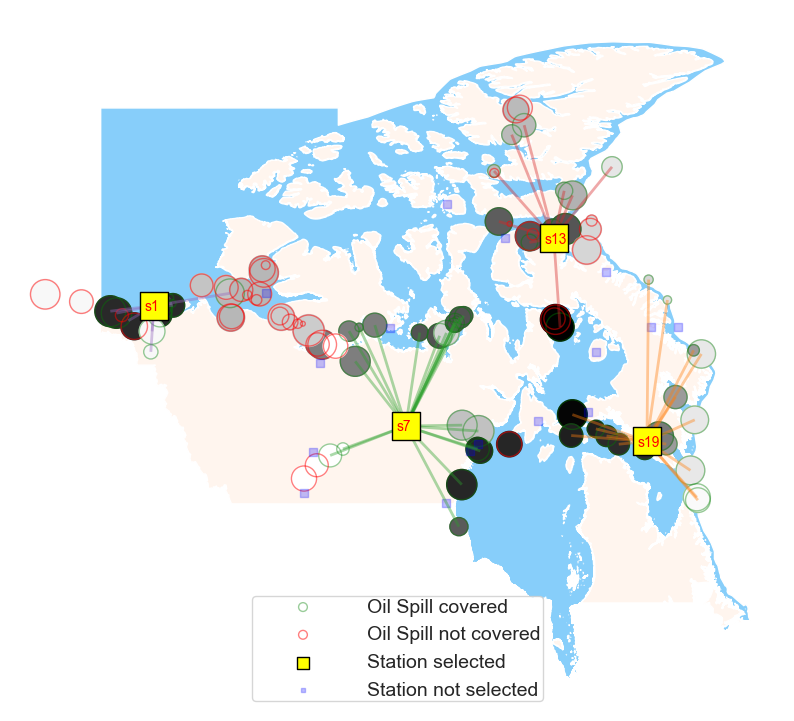

In [9]:
# Draw Network Diagram
assignment_line_m1 = model_analysis.draw_network_diagram(DistanceMax, NumberStMax_m1, Sensitivity_R, spill_df, station_df, MeanResponseTime, coverage_percentage,
                         assignment, deploy_1s, select_1s, current_vs_proposed)

## Resource allocation from facilities (Table 5)

In [10]:
assignment_line_m1 = pd.DataFrame(columns=list(assignment.columns.values))
for i, o in enumerate(assignment['Spill #'].unique()):
    minD = min(assignment.loc[assignment['Spill #'] == o]['Distance'])
    df = assignment.iloc[np.where(assignment['Distance'] == minD)[0]]
    assignment_line_m1 = pd.concat([assignment_line_m1, df])

resource_allocation_m1 = assignment_line_m1[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_m1 = resource_allocation_m1.sort_values(by=['Station no.'])
resource_allocation_m1 = resource_allocation_m1.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_m1['Facility'] = 'Proposed'
resource_allocation_m1

,Station no.,Resource Type,Quantity deployed,Facility
0,s1,c,70.500000,Proposed
1,s1,i,17.000000,Proposed
2,s13,i,55.750000,Proposed
3,s13,m,51.000000,Proposed
4,s19,c,46.142857,Proposed
5,s19,i,27.000000,Proposed
6,s19,m,51.714286,Proposed
7,s7,c,40.000000,Proposed
8,s7,i,67.000000,Proposed
9,s7,m,21.142857,Proposed


## Inputs & Outputs

In [11]:
objValues

[1006.0030204332526,
 -1683.7303888888896,
 1006.0030204332526,
 525.0,
 836.519955528461,
 500.0]

In [12]:
input_output_df = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)','Objective 1', 'Objective 2', 'Coverage Percentage', 'Mean Response Time'])
input_output_df.iloc[0,0] = NumberStMax_m1
input_output_df.iloc[0,1] = DistanceMax
input_output_df.iloc[0,2] = objValues[0::2]
input_output_df.iloc[0,3] = objValues[1::2]
input_output_df.iloc[0,4] = coverage_percentage
input_output_df.iloc[0,5] = MeanResponseTime
input_output_df

,Max no of stations,Max distance (kms),Objective 1,Objective 2,Coverage Percentage,Mean Response Time
0,4,10,"[1006.0030204332526, 1006.0030204332526, 836.5...","[-1683.7303888888896, 525.0, 500.0]",78,7.84


# Model Configuration 2

In [13]:
NumberStMax_m2 = 8

In [14]:
model02, select_m2, deploy_m2, mvars_m2, names_m2, values_m2, objValues_m2, \
        spill_df_m2, station_df_m2, cover_1s_m2, select_1s_m2, deploy_1s_m2, MeanResponseTime_m2, coverage_percentage_m2, assignment_m2  \
    = model.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m2, Distance, Distance_n,
          W, QuantityMin, DistanceMax, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
cover
{('o74', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's14'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o74', 's19'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's13'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's15'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's16'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's17'): <gurobi.Var *Awaiting Model Update*>, ('o98', 's18'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's7'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's8'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's10'): <gurobi.Var *Awaiting Model Update*>, ('o53', 's11'): <gurobi.Var *Awaiting Model Update*>, ('o178', 's2'): <gurobi.Var *Awaiting Model Update*>, ('o203', 's18'): <gurobi.Var *Awaiting Model Update*>, ('o203', 's19'): <gurobi.Var *Awaiting Model U

H:\My Drive\PhD Tan 2023\Python Implementation of MIPs\MIP-Python-Lamoscad\mip_venv\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
H:\My Drive\PhD Tan 2023\Python Implementation of MIPs\MIP-Python-Lamoscad\mip_venv\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


,Spill #,Station no.,St_Latitude,St_Longitude,Spill_Latitude,Spill_Longitude,Resource Type,Quantity deployed,Distance
0,o74,s15,71.709999,-74.970001,64.504219,-79.406021,c,31.0,8.461769
2,o98,s15,71.709999,-74.970001,73.858727,-77.062927,c,31.0,2.999561
4,o127,s15,71.709999,-74.970001,69.348618,-81.734749,c,5.0,7.165049
7,o51,s12,73.400002,-88.160004,73.861763,-82.001617,i,37.0,6.175674
10,o7,s18,68.930000,-69.169998,70.286461,-67.008385,i,37.0,2.551971
...,...,...,...,...,...,...,...,...,...
136,o192,s1,70.000000,-134.000000,68.705536,-134.233826,i,7.0,1.315413
137,o24,s2,70.639999,-119.430000,71.026360,-127.767967,m,2.0,8.346914
138,o175,s2,70.639999,-119.430000,69.407196,-123.965919,c,31.0,4.700465
139,o37,s2,70.639999,-119.430000,70.920486,-124.564491,m,2.0,5.142146


H:\My Drive\PhD Tan 2023\Python Implementation of MIPs\MIP-Python-Lamoscad\mip_venv\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


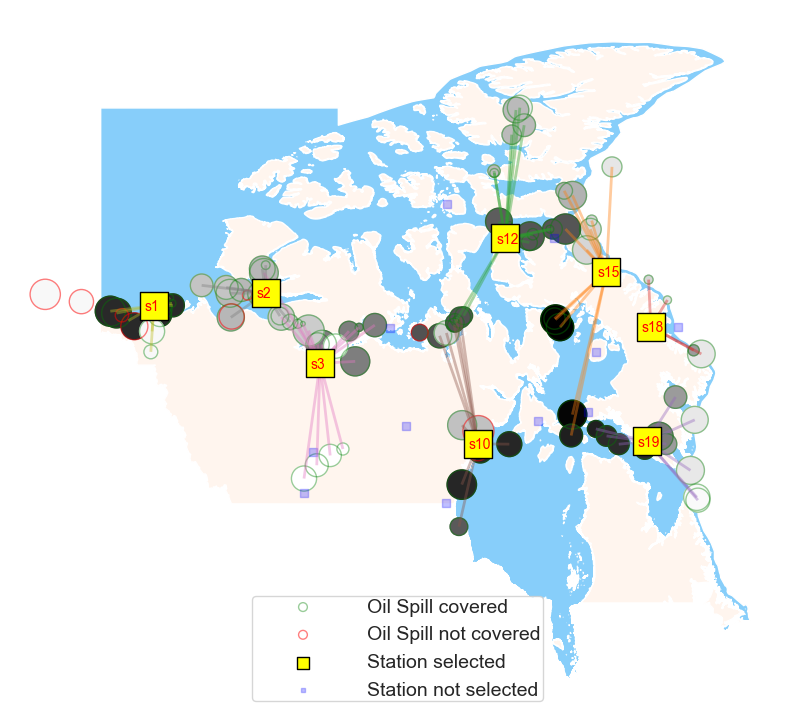

In [15]:
# Draw Network diagram
model_analysis.draw_network_diagram(DistanceMax, NumberStMax_m2, Sensitivity_R, spill_df_m2, station_df_m2, MeanResponseTime_m2, coverage_percentage_m2, assignment_m2, deploy_1s_m2, select_1s_m2, current_vs_proposed)

## Input & Output

In [16]:
input_output_df_m2 = pd.DataFrame(index=range(1), columns=['Max no of stations', 'Max distance (kms)','Objective 1', 'Objective 2', 'Coverage Percentage', 'Mean Response Time'])
input_output_df_m2.iloc[0,0] = NumberStMax_m2
input_output_df_m2.iloc[0,1] = DistanceMax
input_output_df_m2.iloc[0,2] = objValues_m2[0::2]
input_output_df_m2.iloc[0,3] = objValues_m2[1::2]
input_output_df_m2.iloc[0,4] = coverage_percentage_m2
input_output_df_m2.iloc[0,5] = MeanResponseTime_m2
input_output_df_m2

,Max no of stations,Max distance (kms),Objective 1,Objective 2,Coverage Percentage,Mean Response Time
0,8,10,"[1149.1868624083118, 1149.27838707549, 1149.27...","[-7558.88438888889, -5959.718749999999, 1325.0...",99,7.53


# Pareto Front


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
data_pareto_front = pd.read_excel('Outputs/pareto front.xlsx', sheet_name='pareto front2')
data_pareto_front

FileNotFoundError: [Errno 2] No such file or directory: 'Outputs/pareto front.xlsx'

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(data=data_pareto_front, x='Max Coverage', y='Min Cost',
            alpha=0.5, edgecolors='b', s=200, color='g')
plt.xlabel('Max Coverage')
plt.ylabel('Min Cost')
plt.grid(False)
plt.tight_layout()
plt.savefig('Outputs/pareto_front.png', transparent=True)

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(data=data_pareto_front, x='Max Coverage', y='Min Cost',
            alpha=0.5, edgecolors='b', s=200, color='g')
plt.scatter(data=data_pareto_front, x='Max', y='Min',
            alpha=0.5, edgecolors='black', s=200, color='r')
Max = data_pareto_front[['Max']]
Min = data_pareto_front[['Min']]
plt.plot(Max, Min,
            ls='--', alpha=0.5, color='r')
plt.xlabel('Max Coverage')
plt.ylabel('Min Cost')
plt.grid(False)
plt.tight_layout()
#plt.axis('off')
plt.savefig('Outputs/pareto_frontier_points.png', transparent=True)